In [2]:
from transformers import AutoTokenizer
import torch
import os
import pandas as pd
import numpy as np
import pickle
import glob
import re
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.notebook import tqdm
import seaborn as sns
import string
import sys
sys.path.append('..')
from utils import get_segmentation_indices,segmentation_to_word_list,model_to_path_dict
from utils import calculate_cross_entropy,normalize_entropy

In [5]:
story = 'wheretheressmoke'
save_dir = '../../generated'
behavior_data_dir = '../../behavior_data'
model_name = 'Llama3-8b-instruct'
model_save_dir_name = model_to_path_dict[model_name]['save_dir_name']
model_initial_char = model_to_path_dict[model_name]['initial_char']
tokenizer = AutoTokenizer.from_pretrained(model_to_path_dict[model_name]['hf_name'])

moth_output_dir = os.path.join(save_dir,model_save_dir_name,'moth_stories_output')
with open(os.path.join(moth_output_dir,story,'cross_entropy.pkl'),'rb') as f:
    original_ce = pickle.load(f)
# tokenized txt 
with open(os.path.join(moth_output_dir,story,'tokenized_txt.pkl'),'rb') as f:
    tokenized_txt = pickle.load(f)
story_tokens = torch.load(os.path.join(moth_output_dir,story,'tokens.pkl'))
story_tokens = story_tokens[0,1:].cpu().detach()

segmentation_dir = os.path.join(behavior_data_dir,'segmentation')
consensus_path = os.path.join(segmentation_dir,story,'%s_consensus.txt'%story)
with open(consensus_path,'r') as f:
    consensus_txt = f.read()
consensus_txt = consensus_txt.split('\n')
moth_output_dir = os.path.join(save_dir,model_save_dir_name,'moth_stories_output')
original_transcript_dir = os.path.join(behavior_data_dir,'transcripts','moth_stories')
with open(os.path.join(original_transcript_dir,'%s.txt'%story),'r') as f:
    original_txt = f.read()

In [6]:
def split_string_into_chunks(text, chunk_size=10):
    words = text.split()
    return [' '.join(words[0:i+chunk_size]) for i in range(0, len(words), chunk_size)]

In [7]:
verbatim_recall_save_dir = os.path.join(save_dir,model_save_dir_name,'verbatim_recall')
if not os.path.exists(os.path.join(verbatim_recall_save_dir,'%s_verbatim_recall_transcripts.csv'%story)):
    split_original_txt = split_string_into_chunks(original_txt)
    verbatim_df = pd.DataFrame({'subject':np.arange(len(split_original_txt)),'corrected transcript':split_original_txt})
    if not os.path.exists(verbatim_recall_save_dir):
        os.makedirs(verbatim_recall_save_dir)
    verbatim_df.to_csv(os.path.join(verbatim_recall_save_dir,'%s_verbatim_recall_transcripts.csv'%story),index = False)
else:
    verbatim_df = pd.read_csv(os.path.join(verbatim_recall_save_dir,'%s_verbatim_recall_transcripts.csv'%story))

In [8]:
verbatim_recall_story_dir = os.path.join(verbatim_recall_save_dir,story)
with open(os.path.join(verbatim_recall_story_dir,'recall_original_concat_entropy.pkl'),'rb') as f:
    recall_original_concat_entropy = pickle.load(f)
with open(os.path.join(verbatim_recall_story_dir,'recall_original_concat.pkl'),'rb') as f:
    recall_original_tokens_dict = pickle.load(f)
with open(os.path.join(verbatim_recall_story_dir,'recall_tokens.pkl'),'rb') as f:
    recall_tokens_dict = pickle.load(f)
with open(os.path.join(verbatim_recall_story_dir,'recall_entropy.pkl'),'rb') as f:
    recall_entropy = pickle.load(f)
assert len(recall_original_concat_entropy) == len(recall_tokens_dict['subject_id'])

In [9]:
word_initial_bool = np.array([True if model_initial_char in t else False for t in tokenized_txt])
ce_diff = []
ce_diff_initial_only = []

for i,concat_ce in enumerate(recall_original_concat_entropy):
    start_index = recall_original_tokens_dict['original_transcript_start_index'][i]-1 # because there's no BOS in the entropy array 
    post_recall_ce = concat_ce[start_index:]
    assert original_ce.shape == post_recall_ce.shape
    d = (post_recall_ce-original_ce).numpy()
    d_initial_only = d.copy()
    d_initial_only[~word_initial_bool] = np.nan
    ce_diff.append(d)
    ce_diff_initial_only.append(d_initial_only)
    
ce_diff = np.array(ce_diff)
ce_diff_initial_only= np.array(ce_diff_initial_only)
sum_ce_diff = -np.sum(ce_diff,axis = 1)

In [11]:
import polyleven
def word_level_edit_distance_polyleven(str1, str2):
    # Step 1: Split the strings into words
    str1 = str1.lower()
    str2 = str2.lower()
    words1 = str1.split()
    words2 = str2.split()

    # Step 2: Create a unique mapping for words
    unique_words = list(set(words1 + words2))
    word_to_char = {word: chr(i + 97) for i, word in enumerate(unique_words)}

    # Step 3: Convert the word sequences into character sequences
    seq1 = ''.join([word_to_char[word] for word in words1])
    seq2 = ''.join([word_to_char[word] for word in words2])

    # Step 4: Calculate the edit distance using polyleven
    distance = polyleven.levenshtein(seq1, seq2)
    
    return distance
def clean_recall(recall_txt):
    punctuation_to_remove = string.punctuation.replace("'", "") + "\n" 
    str_to_rm = str.maketrans("", "", punctuation_to_remove)
    if isinstance(recall_txt,str):
        r = recall_txt.replace('<|eot_id|>', '')
        r = r.translate(str_to_rm)
        return r
    else:
        cleaned_recall = []
        for r in recall_txt:
            r = r.replace('<|eot_id|>', '')
            r = r.translate(str_to_rm)
            cleaned_recall.append(r)
        return cleaned_recall

In [12]:
verbatim_recall_txt = verbatim_df['corrected transcript'].values
verbatim_recall_txt = clean_recall(verbatim_recall_txt)
verbatim_levenshtein_d = [word_level_edit_distance_polyleven(original_txt,r) for r in verbatim_recall_txt]
verbatim_levenshtein_d = np.array(verbatim_levenshtein_d)

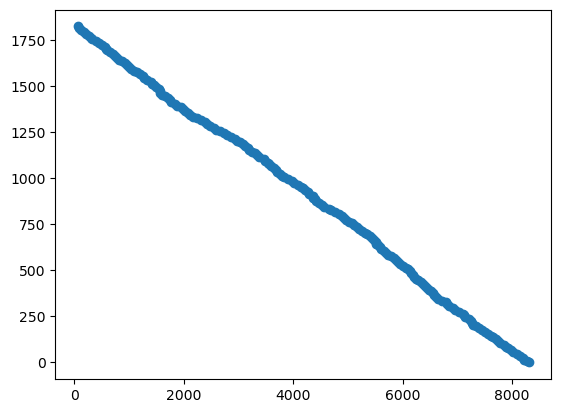

In [13]:
plt.scatter(sum_ce_diff,verbatim_levenshtein_d)